# Practice_cGAN_v1

- References
    - https://deep-learning-study.tistory.com/641
    - https://github.com/eriklindernoren/PyTorch-GAN?tab=readme-ov-file
    - https://jh-bk.tistory.com/19

# Library

In [69]:
import os
import numpy as np
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
to_pil_image = ToPILImage()

import torchvision.datasets as datasets

In [46]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device :", device)

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

device : cuda:0
Random Seed:  42


# Path

In [62]:
path_cwd = os.getcwd()
print("path_cwd: ", path_cwd)

path_data = path_cwd + '\\data\\' # celeba\\
os.makedirs(path_data, exist_ok=True)
print("path_data: ", path_data)

path_save = path_data + 'model\\' # celeba\\
os.makedirs(path_save, exist_ok=True)
print("path_save: ", path_save)

path_cwd:  C:\Users\user\Desktop\SHLee\Code\GM\CGAN
path_data:  C:\Users\user\Desktop\SHLee\Code\GM\CGAN\data\
path_save:  C:\Users\user\Desktop\SHLee\Code\GM\CGAN\data\model\


# Dataset

In [48]:
# Transformation 정의
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.5],[0.5])
])

# MNIST dataset 불러오기
train_ds = datasets.MNIST(path_data, train=True, 
                          transform=train_transform, download=True)

In [49]:
# 샘플 이미지 확인하기
img, label = train_ds.data, train_ds.targets

print(type(img)) # torch.Tensor type이므로, (데이터개수, h, w) 순서
print(np.shape(img))

# 차원 추가
if len(img.shape) == 3:
    img = img.unsqueeze(1) # B*C*H*W

<class 'torch.Tensor'>
torch.Size([60000, 28, 28])


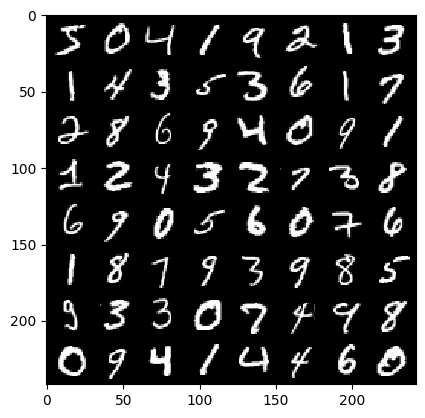

In [50]:
# 그리드 생성
img_grid = utils.make_grid(img[:64], nrow=8, padding=2)

def show(img):
    npimg = img.numpy()
    npimg_tr = npimg.transpose((1,2,0)) # [C,H,W] -> [H,W,C]
    plt.imshow(npimg_tr, interpolation='nearest')

show(img_grid)

In [51]:
# 데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# Model

## Hyper-parameter

In [52]:
# 파라미터 설정
params = {'num_classes':10,
          'nz':100,
          'input_size':(1,28,28)}

## Generator

In [53]:
# Generator: 가짜 이미지를 생성합니다.
# noise와 label을 결합하여 학습합니다.

class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes'] # 클래스 수, 10
        self.nz = params['nz'] # 노이즈 수, 100
        self.input_size = params['input_size'] # (1,28,28)

        # noise와 label을 결합할 용도인 label embedding matrix를 생성합니다.
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # noise와 label 결합
        gen_input = torch.cat((self.label_emb(labels),noise),-1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x

# check
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


## Discriminator

In [54]:
# Discriminator: 가짜 이미지와 진짜 이미지를 식별합니다.
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']

        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)

        x = self.dis(dis_input)
        return x

# check
x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


## Initialization

In [55]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights)
model_dis.apply(initialize_weights)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (dis): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

## Loss & Optimizer

In [56]:
# Loss
loss_func = nn.BCELoss()

# optimizer
from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2))

# Training

In [57]:
# 학습 파라미터
nz = params['nz']
num_epochs = 100
batch_size = 64
print("nz:", nz)
print("num_epochs:", num_epochs)
print("batch_size:", batch_size)

loss_history={'gen':[],
              'dis':[]}

nz: 100
num_epochs: 100
batch_size: 64


In [58]:
# keep track
img_list = []

# training
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()
iters = 0

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ############################
        # (0) Real batch dataset
        ###########################
        ba_si = xb.shape[0]
        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device) # fake_label

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        model_dis.zero_grad()

        # Real
        out_dis = model_dis(xb, yb) # Real
        lossD_real = loss_func(out_dis, yb_real) # BCE lossD_real
        lossD_real.backward()
        D_x = out_dis.mean().item() # 출력의 평균값, 1에 가까울수록 구분 잘함.

        # Fake
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성 - 왜 label을 생성?
        out_gen = model_gen(noise, gen_label) # G로 만들기
        out_dis = model_dis(out_gen.detach(),gen_label) # G로 만든거 D로 판단하기
        lossD_fake = loss_func(out_dis,yb_fake) # lossD_fake
        lossD_fake.backward()
        D_G_z1 = out_dis.mean().item() # 출력의 평균값, 0.5에 가까울수록 G가 잘 만듦.
        
        # 최종 Loss
        lossD = lossD_real + lossD_fake
        
        # D 업데이트!
        opt_dis.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_gen.zero_grad()
        
        out_dis = model_dis(out_gen, gen_label) # G로 만든거 D로 판별하기

        lossG = loss_func(out_dis, yb_real) # 1이 되게끔 속여야 하니까 yb_real과의 loss 계산
        lossG.backward()
        D_G_z2 = out_dis.mean().item()

        # G 업데이트! - 어떻게해야 D를 잘 속일지 가중치 업데이트
        opt_gen.step()

        
        ############################
        # (3) Check the progress
        ###########################
        loss_history['dis'].append(lossD.item())
        loss_history['gen'].append(lossG.item())

        batch_count += 1
        if batch_count % 50 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' 
                  %(epoch, lossG.item(), lossD.item(), (time.time()-start_time)/60))

        # G가 잘 학습되고 있나 확인하기 위한 부분 fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (iters == len(train_dl)-1)):
            with torch.no_grad():
                fake = model_gen(noise, gen_label).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Epoch: 0, G_Loss: 0.971911, D_Loss: 1.214573, time: 0.01 min
Epoch: 0, G_Loss: 0.681321, D_Loss: 1.448071, time: 0.02 min
Epoch: 0, G_Loss: 0.814615, D_Loss: 1.279400, time: 0.03 min
Epoch: 0, G_Loss: 0.940448, D_Loss: 1.277933, time: 0.03 min
Epoch: 0, G_Loss: 1.028936, D_Loss: 1.297230, time: 0.04 min
Epoch: 0, G_Loss: 0.901960, D_Loss: 1.237079, time: 0.05 min
Epoch: 0, G_Loss: 0.727775, D_Loss: 1.273856, time: 0.06 min
Epoch: 0, G_Loss: 1.721064, D_Loss: 1.106979, time: 0.07 min
Epoch: 0, G_Loss: 0.945483, D_Loss: 1.252670, time: 0.08 min
Epoch: 0, G_Loss: 1.022077, D_Loss: 1.208466, time: 0.09 min
Epoch: 0, G_Loss: 0.938295, D_Loss: 1.235562, time: 0.09 min
Epoch: 0, G_Loss: 0.831235, D_Loss: 1.241833, time: 0.10 min
Epoch: 0, G_Loss: 1.210463, D_Loss: 1.086801, time: 0.11 min
Epoch: 0, G_Loss: 1.106171, D_Loss: 1.113395, time: 0.12 min
Epoch: 0, G_Loss: 0.767347, D_Loss: 1.221166, time: 0.13 min
Epoch: 0, G_Loss: 0.844283, D_Loss: 1.049049, time: 0.14 min
Epoch: 0, G_Loss: 1.0877

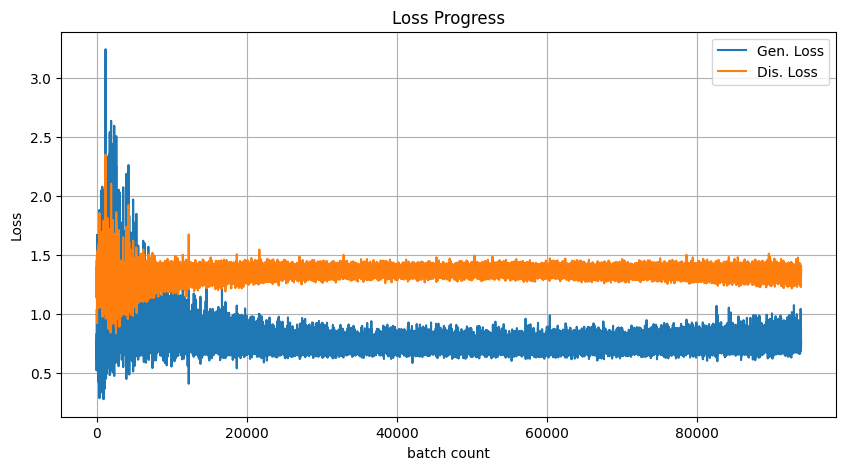

In [60]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [71]:
np.log(0.5)

-0.6931471805599453

In [65]:
# 가중치 저장
path_weights_gen = os.path.join(path_save, 'weights_gen.pt')
path_weights_dis = os.path.join(path_save, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path_weights_gen)
torch.save(model_dis.state_dict(), path_weights_dis)

# 가짜 이미지 확인하기

In [66]:
# 가중치 불러오기
weights = torch.load(path_weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

Generator(
  (label_emb): Embedding(10, 10)
  (gen): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [67]:
# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise, label).detach().cpu()
    
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


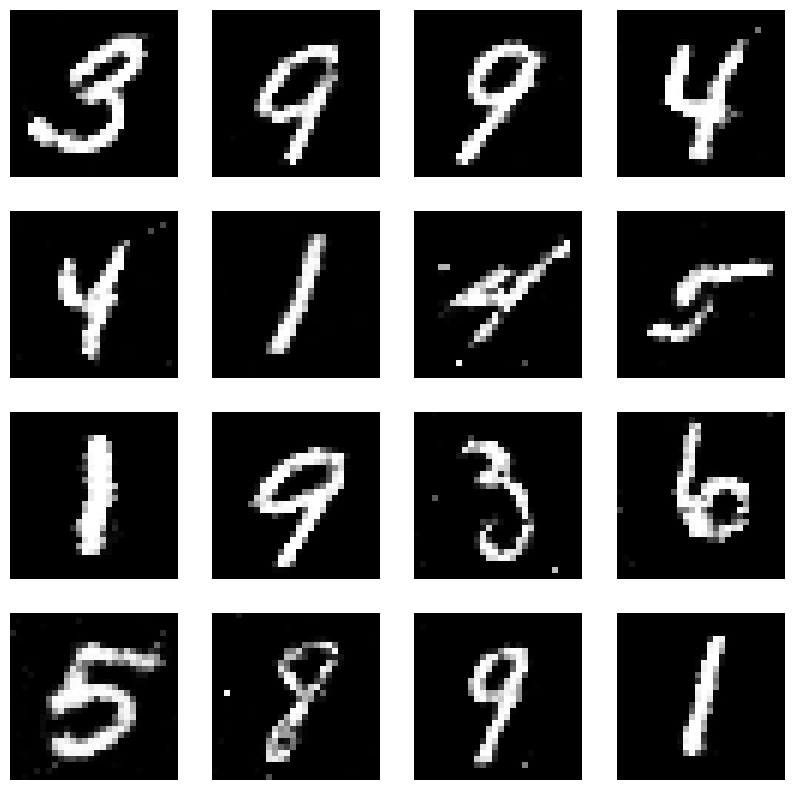

In [70]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')